In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

from keras.layers import Dense, LSTM, Dropout, Input, Flatten, Conv1D, BatchNormalization, Concatenate
from keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

# Data Compilation

In [6]:
#Reading one of the data files
pd.read_csv('/data/2.5_2021.csv')

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2021,AQS,320030024,3,3.0,ug/m3 LC,13,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
1,01/02/2021,AQS,320030024,3,5.3,ug/m3 LC,22,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
2,01/03/2021,AQS,320030024,3,4.1,ug/m3 LC,17,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
3,01/04/2021,AQS,320030024,3,4.5,ug/m3 LC,19,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
4,01/05/2021,AQS,320030024,3,3.8,ug/m3 LC,16,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7364,06/03/2021,AQS,325100020,2,5.4,ug/m3 LC,23,Carson City Armory,1,100.0,88101,PM2.5 - Local Conditions,16180,"Carson City, NV",32,Nevada,510,Carson City,39.144700,-119.766100
7365,06/09/2021,AQS,325100020,2,3.8,ug/m3 LC,16,Carson City Armory,1,100.0,88101,PM2.5 - Local Conditions,16180,"Carson City, NV",32,Nevada,510,Carson City,39.144700,-119.766100
7366,06/15/2021,AQS,325100020,2,2.7,ug/m3 LC,11,Carson City Armory,1,100.0,88101,PM2.5 - Local Conditions,16180,"Carson City, NV",32,Nevada,510,Carson City,39.144700,-119.766100
7367,06/21/2021,AQS,325100020,2,4.3,ug/m3 LC,18,Carson City Armory,1,100.0,88101,PM2.5 - Local Conditions,16180,"Carson City, NV",32,Nevada,510,Carson City,39.144700,-119.766100


In [7]:
#Compiling all related data in one dataframe
add = []
leng = 0
for item in os.listdir('/data'):
  if '.csv' in item:
    temp = pd.read_csv('/data/' + item)
    add.append(temp)
    leng += len(pd.read_csv('/data/' + item))

compiled = pd.concat(add)

In [8]:
compiled

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2021,AQS,320030024,3,3.0,ug/m3 LC,13,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820.0,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
1,01/02/2021,AQS,320030024,3,5.3,ug/m3 LC,22,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820.0,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
2,01/03/2021,AQS,320030024,3,4.1,ug/m3 LC,17,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820.0,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
3,01/04/2021,AQS,320030024,3,4.5,ug/m3 LC,19,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820.0,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
4,01/05/2021,AQS,320030024,3,3.8,ug/m3 LC,16,NaN,1,100.0,88101,PM2.5 - Local Conditions,29820.0,"Las Vegas-Henderson-Paradise, NV",32,Nevada,3,Clark,36.815897,-114.050347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,12/15/1999,AQS,320330101,1,1.8,ug/m3 LC,8,Great Basin NP - Maintenance Yard,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,NaN,NaN,32,Nevada,33,White Pine,39.005120,-114.215930
1135,12/18/1999,AQS,320330101,1,1.7,ug/m3 LC,7,Great Basin NP - Maintenance Yard,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,NaN,NaN,32,Nevada,33,White Pine,39.005120,-114.215930
1136,12/22/1999,AQS,320330101,1,1.7,ug/m3 LC,7,Great Basin NP - Maintenance Yard,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,NaN,NaN,32,Nevada,33,White Pine,39.005120,-114.215930
1137,12/25/1999,AQS,320330101,1,1.0,ug/m3 LC,4,Great Basin NP - Maintenance Yard,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,NaN,NaN,32,Nevada,33,White Pine,39.005120,-114.215930


In [9]:
#Checking if compilation was successful
len(compiled) == leng

True

# Visualizing Data

In [10]:
#Tranforming date column to correct format
compiled["Date"] = pd.to_datetime(compiled["Date"])

In [11]:
compiled['Date']

0      2021-01-01
1      2021-01-02
2      2021-01-03
3      2021-01-04
4      2021-01-05
          ...    
1134   1999-12-15
1135   1999-12-18
1136   1999-12-22
1137   1999-12-25
1138   1999-12-29
Name: Date, Length: 86217, dtype: datetime64[ns]

In [12]:
#If multiple readings on same date, taking average of the values
compiled = compiled[['Date', 'Daily Mean PM2.5 Concentration']].groupby(by = ['Date']).mean()

In [13]:
compiled

,Daily Mean PM2.5 Concentration
Date,
1999-01-02,1.250000
1999-01-03,9.375000
1999-01-06,22.842857
1999-01-09,7.850000
1999-01-12,7.860000
...,...
2021-12-24,1.623810
2021-12-25,3.009524
2021-12-26,1.738095


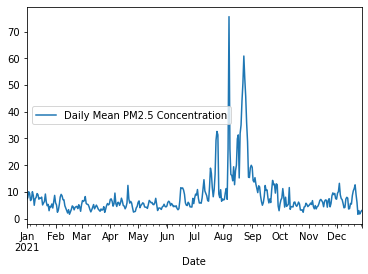

In [14]:
#Plotting data for year 2021
compiled[compiled.index.year == 2021].plot()

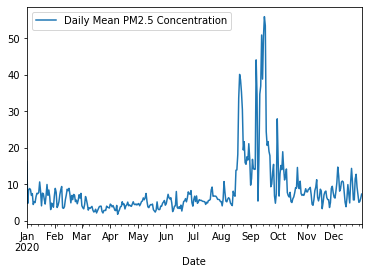

In [15]:
#Plotting data for year 2020
compiled[compiled.index.year == 2020].plot()

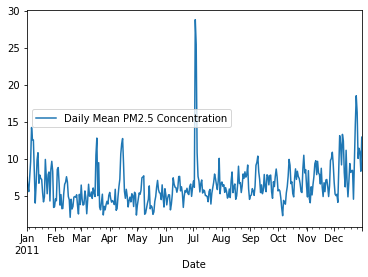

In [16]:
#Plotting data for year 2011
compiled[compiled.index.year == 2011].plot()

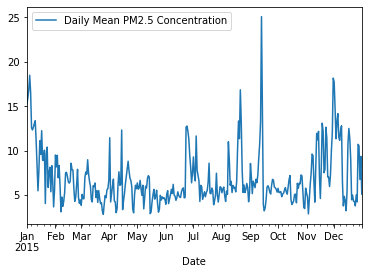

In [17]:
#Plotting data for year 2015
compiled[compiled.index.year == 2015].plot()

# Data Pre-Processing

In [18]:
#normalizing the values for better predictions
scaler = MinMaxScaler(feature_range=(0,1))

# reshape the data before calling scaler.fit_transform because it works only on np arrays
compiled = scaler.fit_transform(np.array(compiled).reshape(-1,1))

In [19]:
compiled

array([[0.00734312],
       [0.11582109],
       [0.29563227],
       ...,
       [0.01385975],
       [0.0233327 ],
       [0.03102549]])

In [20]:
training_size = int(0.7*compiled.shape[0])
test_size = compiled.shape[0] - training_size
train_data = compiled[:training_size, :]
test_data = compiled[training_size:, :]

In [21]:
train_data

array([[0.00734312],
       [0.11582109],
       [0.29563227],
       ...,
       [0.09490432],
       [0.06734906],
       [0.04791574]])

In [22]:
compiled.shape

(8336, 1)

In [23]:
train_data.shape

(5835, 1)

In [24]:
window_size = 200

In [25]:
x_train, y_train = [], []
for i in range(window_size, train_data.shape[0]):         # a single prediction on the basis of the last 200 days
  x_train.append(train_data[i-window_size:i,0])
  y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))      # to make the input size compatible with the LSTM input size

In [26]:
x_train.shape

(5635, 200, 1)

In [27]:
x_test, y_test = [], []
for i in range(window_size, test_data.shape[0]):
  x_test.append(test_data[i-window_size:i, :])
  y_test.append(test_data[i,:])

x_test, y_test = np.array(x_test), np.array(y_test)

In [28]:
x_test.shape

(2301, 200, 1)

In [29]:
x_test.shape

(2301, 200, 1)

In [30]:
y_test_original = scaler.inverse_transform(y_test)

# Dense Neural Network

In [ ]:
inp = Input(shape = (x_train.shape[1], x_train.shape[2]))

x = Flatten()(inp)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
last = Dense(1, activation="linear")(x)

dnn_model = Model(inputs = inp, outputs = last)
dnn_model.summary()

dnn_model.compile(loss='mean_squared_error', optimizer='adam')
dnn_model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs= 100, batch_size= 64, verbose=1)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 1)]          0         
                                                                 
 flatten_8 (Flatten)         (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               25728     
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,889
Trainable params: 29,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 [==============================] - 1s

In [ ]:
y_pred_dnn = scaler.inverse_transform(dnn_model.predict(x_test))

rmse_score_dnn = math.sqrt(mean_squared_error(y_test_original, y_pred_dnn))
print('Root Mean Squared Error : ',rmse_score_dnn)
print('R-squared Score  : ',r2_score(y_test_original,y_pred_dnn))

Root Mean Squared Error :  4.1454007871760785
R-squared Score  :  0.4045933575234957


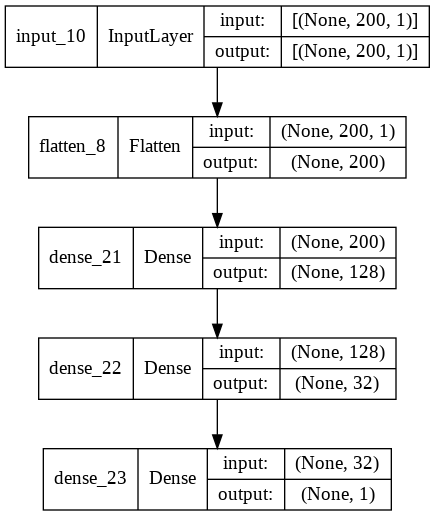

In [ ]:
plot_model(dnn_model, show_shapes=True)

In [ ]:
dnn_model.save("/models/dnn_model.h5")

# Recurrent Neural Network

In [ ]:
inp = Input(shape = (x_train.shape[1], x_train.shape[2]))

x = LSTM(units = 50, input_shape = (x_train.shape[1],1), return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = LSTM(units = 50)(x)
last = Dense(units = 1, activation = 'linear')(x)

rnn_model = Model(inputs = inp, outputs = last)
rnn_model.summary()

rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs= 100, batch_size= 64, verbose=1)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200, 1)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 200, 50)           10400     
                                                                 
 dropout_2 (Dropout)         (None, 200, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 [==============================] - 5s

In [ ]:
y_pred_rnn = scaler.inverse_transform(rnn_model.predict(x_test))

rmse_score_rnn = math.sqrt(mean_squared_error(y_test_original, y_pred_rnn))
print('Root Mean Squared Error : ',rmse_score_rnn)
print('R-squared Score  : ',r2_score(y_test_original,y_pred_rnn))

Root Mean Squared Error :  3.3426965967920554
R-squared Score  :  0.6128542083529072


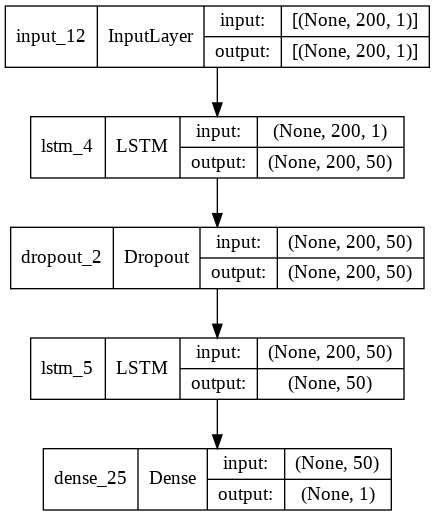

In [ ]:
plot_model(rnn_model, show_shapes=True)

In [ ]:
rnn_model.save("/models/rnn_model.h5")

# Convolutional Neural Network

In [ ]:
inp = Input(shape = (x_train.shape[1], x_train.shape[2]))

x = Conv1D(16, 128, padding = "valid", strides = 1)(inp)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)
x = Conv1D(32, 64, padding = "valid", strides = 1)(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)
x = Flatten()(x)
last = Dense(1, activation="linear")(x)

cnn_model = Model(inputs = inp, outputs = last)
cnn_model.summary()

cnn_model.compile(loss='mean_squared_error', optimizer='adam')
cnn_model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs= 100, batch_size= 64, verbose=1)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 73, 16)            2064      
                                                                 
 batch_normalization_2 (Batc  (None, 73, 16)           64        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 73, 16)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 32)            32800     
                                                                 
 batch_normalization_3 (Batc  (None, 10, 32)           128       
 hNormalization)                                          

In [ ]:
y_pred_cnn = scaler.inverse_transform(cnn_model.predict(x_test))

rmse_score_cnn = math.sqrt(mean_squared_error(y_test_original, y_pred_cnn))
print('Root Mean Squared Error : ',rmse_score_cnn)
print('R-squared Score  : ',r2_score(y_test_original,y_pred_cnn))

Root Mean Squared Error :  3.841779178729176
R-squared Score  :  0.4886180189100492


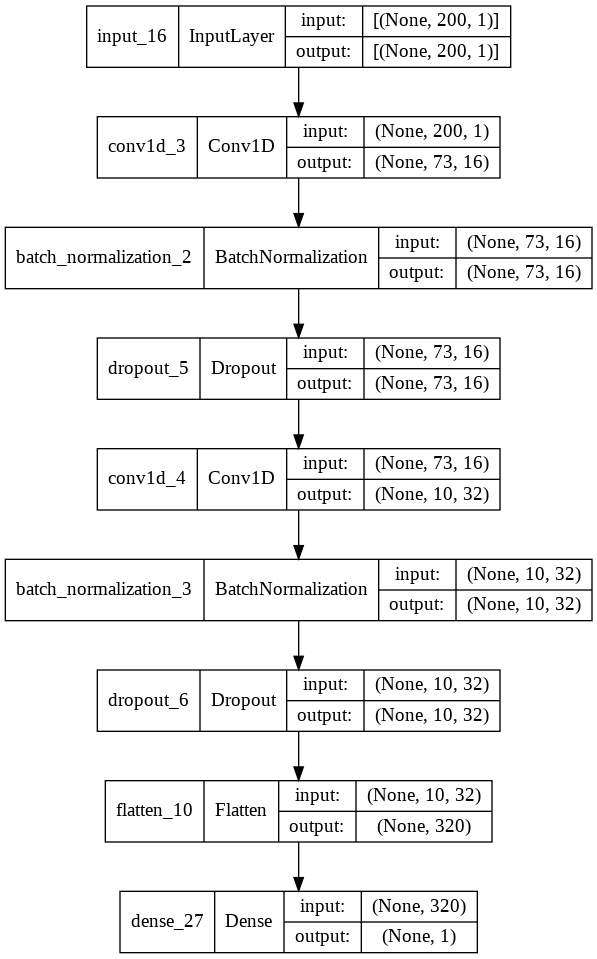

In [ ]:
plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.save("/models/cnn_model.h5")

# Ensemble Model

In [ ]:
inp = Input(shape = (x_train.shape[1], x_train.shape[2]))

rnn_out = rnn_model(inp)
cnn_out = cnn_model(inp)
x = Concatenate()([rnn_out, cnn_out])
last = Dense(1, activation="linear")(x)

ensemble_model = Model(inputs = inp, outputs = last)
ensemble_model.summary()

ensemble_model.compile(loss='mean_squared_error', optimizer='adam')
ensemble_model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs= 100, batch_size= 64, verbose=1)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 model_9 (Functional)           (None, 1)            30651       ['input_21[0][0]']               
                                                                                                  
 model_11 (Functional)          (None, 1)            35377       ['input_21[0][0]']               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 2)            0           ['model_9[4][0]',                
                                                                  'model_11[4][0]']        

In [ ]:
y_pred_ensemble = scaler.inverse_transform(ensemble_model.predict(x_test))

rmse_score_ensemble = math.sqrt(mean_squared_error(y_test_original, y_pred_ensemble))
print('Root Mean Squared Error : ',rmse_score_ensemble)
print('R-squared Score  : ',r2_score(y_test_original,y_pred_ensemble))

Root Mean Squared Error :  3.3941193160606593
R-squared Score  :  0.6008511935077527


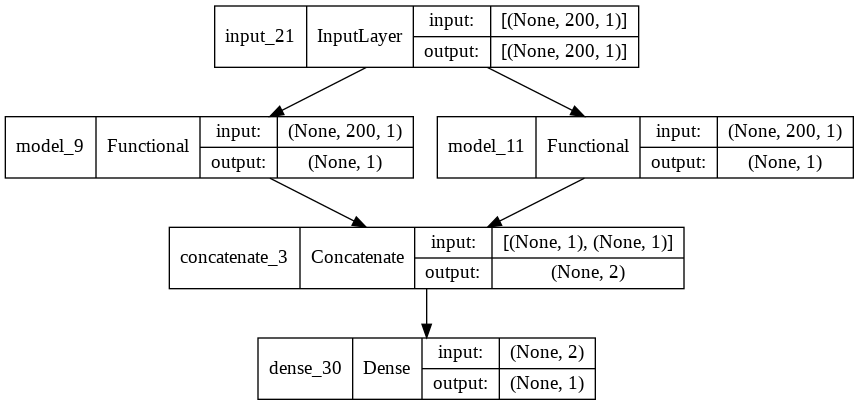

In [ ]:
plot_model(ensemble_model, show_shapes=True)

In [ ]:
ensemble_model.save("/models/ensemble_model.h5")

# Visualizing Predictions

In [31]:
# load model
dnn_model = load_model('/models/dnn_model.h5')
rnn_model = load_model('/models/rnn_model.h5')
cnn_model = load_model('/models/cnn_model.h5')
ensemble_model = load_model('/models/ensemble_model.h5')

In [32]:
# predictions of models
test_predict_dnn = scaler.inverse_transform(dnn_model.predict(x_test))
test_predict_rnn = scaler.inverse_transform(rnn_model.predict(x_test))
test_predict_cnn = scaler.inverse_transform(cnn_model.predict(x_test))
test_predict_ensemble = scaler.inverse_transform(ensemble_model.predict(x_test))

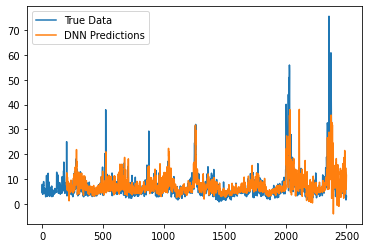

In [33]:
#Plotting DNN Prediction
testPredictPlot_dnn = np.empty_like(test_data)
testPredictPlot_dnn[:, :] = np.nan
testPredictPlot_dnn[window_size:len(test_predict_dnn)+window_size, :] = test_predict_dnn

plt.plot(scaler.inverse_transform(test_data), label='True Data')
plt.plot(testPredictPlot_dnn, label='DNN Predictions')
plt.legend()
plt.show()

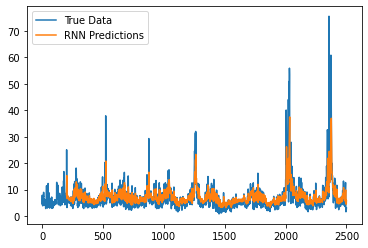

In [34]:
#Plotting RNN Prediction
testPredictPlot_rnn = np.empty_like(test_data)
testPredictPlot_rnn[:, :] = np.nan
testPredictPlot_rnn[window_size:len(test_predict_rnn)+window_size, :] = test_predict_rnn

plt.plot(scaler.inverse_transform(test_data), label='True Data')
plt.plot(testPredictPlot_rnn, label='RNN Predictions')
plt.legend()
plt.show()

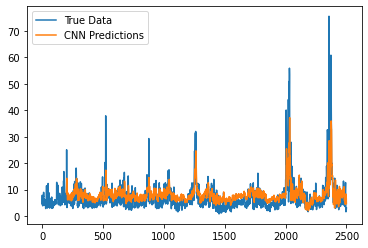

In [35]:
#Plotting CNN Prediction
testPredictPlot_cnn = np.empty_like(test_data)
testPredictPlot_cnn[:, :] = np.nan
testPredictPlot_cnn[window_size:len(test_predict_cnn)+window_size, :] = test_predict_cnn

plt.plot(scaler.inverse_transform(test_data), label='True Data')
plt.plot(testPredictPlot_cnn, label='CNN Predictions')
plt.legend()
plt.show()

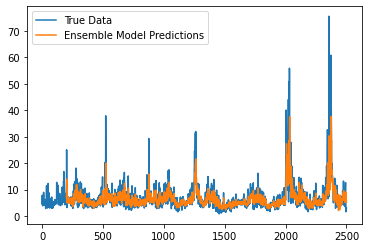

In [36]:
#Plotting Ensemble Model Prediction
testPredictPlot_ensemble = np.empty_like(test_data)
testPredictPlot_ensemble[:, :] = np.nan
testPredictPlot_ensemble[window_size:len(test_predict_ensemble)+window_size, :] = test_predict_ensemble

plt.plot(scaler.inverse_transform(test_data), label='True Data')
plt.plot(testPredictPlot_ensemble, label='Ensemble Model Predictions')
plt.legend()
plt.show()